In [421]:
flex_title = "Dashboard Analisis Indice de competitividad"
flex_orientation = "rows"

In [365]:
#Se cargan las librerias a utilizar
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import dash 
import dash_core_components as dcc
import dash_html_components as html 
from dash.dependencies import Input, Output
import warnings
from scipy import stats

In [366]:
warnings.filterwarnings('ignore')

In [367]:
#Cargamos la base de datos desde el archivo de excel
#Los datos que vamos a usar ya vienen casi tidy, por lo que haremos merge de otras fuentes para 
#demostrar la limpieza de los datos
#Para nuestro caso utlizaremos la tabla indices de todos los años que viene tidy
#este dataframe es el resultado de normalizaciones y calculos de tablas con indicadores separados
#pero haremos merge con el Dataset de vuelos por origen-destino al año de las ciudades que 
#son motivo de estudio
df = pd.read_excel(r'.\data\2020_ICU_Base-de-datos-.xlsx', sheet_name = 'Puntajes', skiprows = 0, nrows=835, usecols = 'B:O')
#Tambien voy a cargar el dataset de la poblacion para tener el tamaño de la ciudad segun la población
df_poblacion = pd.read_excel(r'.\data\2020_ICU_Base-de-datos-.xlsx', sheet_name = 'Cds 2018', skiprows = 6, nrows=74, usecols = 'A,CB:CH')

In [368]:
#Le ponemos nombre a las columnas del data set de poblacion
df_poblacion.columns = ['Ciudad','poblacion','pea','p ocupada','act economica','tamaño','region','PIB']
df_poblacion

,Ciudad,poblacion,pea,p ocupada,act economica,tamaño,region,PIB
0,Aguascalientes,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0
1,Ensenada,518900,261553,250011,5.421094e+07,De 500 mil a un millón,Noroeste,51671717.0
2,Mexicali,1051870,536167,521701,1.915751e+08,Más de un millón,Noroeste,184248600.0
3,Tijuana,1950472,927993,900154,2.209653e+08,Más de un millón,Noroeste,379715954.0
4,La Paz,291685,153434,147490,6.055883e+07,De 250 a 500 mil,Noroeste,32315701.0
...,...,...,...,...,...,...,...,...
68,Poza Rica,563049,245115,235883,5.091256e+07,De 500 mil a un millón,Sur-Sureste,58419309.0
69,Veracruz,940527,344862,331306,1.513935e+08,De 500 mil a un millón,Sur-Sureste,213100679.0
70,Xalapa,804284,383245,358182,6.826475e+07,De 500 mil a un millón,Sur-Sureste,51512164.0
71,Mérida,1207197,624724,606969,2.273801e+08,Más de un millón,Sur-Sureste,184052844.0


In [369]:
#Reviso nombres de columnas, no tiene 
df.columns

Index(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')

In [370]:
#Voy a empezar con la limpieza de los datos
#Tengo en cada cierto numero de columnas en el encabezado el año, aparte tengo los headers repetidos
#revisamos
df[70:80]

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
70,Poza Rica,80,Veracruz,76.3796,63.0016,50.9058,62.6476,46.8797,41.2458,14.6615,29.0611,2.58657,30.6879,41.8057
71,Veracruz,81,Veracruz,80.0932,54.9008,57.7894,62.5987,57.8934,51.0737,25.2317,41.2186,42.558,28.7833,50.2141
72,Xalapa,82,Veracruz,73.0759,65.4096,56.1934,64.978,62.1635,49.8023,18.3812,36.6649,24.3185,25.8136,47.6801
73,Mérida,83,Yucatán,99.1656,61.7962,65.9356,70.6594,70.4832,48.9549,32.8315,58.2523,48.69,20.2206,57.6989
74,Zacatecas- Guadalupe,84,Zacatecas,56.7498,69.2649,61.755,67.2502,53.1247,52.6127,19.0008,43.6769,40.764,23.4251,48.7624
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,Ciudad,Clave cd,Entidad,Derecho,MA,Sociedad,Político,Gobierno,Factores,Economía,Precursores,RI,Innovación,GENERAL
78,Aguascalientes,1,Aguascalientes,91.4441,69.862,49.77,53.7137,61.0005,51.2491,38.2079,40.674,38.011,13.6141,50.7546
79,Ensenada,2,Baja California,81.2582,65.3732,56.2344,58.9827,43.7685,66.9034,37.5777,38.9794,19.1011,18.9278,48.7106


In [371]:
 #Creo las series de los años para buscarlos en las columnas
 s = pd.Series(reversed(range(2010,2019)))

In [372]:
print(s)

0    2018
1    2017
2    2016
3    2015
4    2014
5    2013
6    2012
7    2011
8    2010
dtype: int64


In [373]:
#Ahora saco un arreglo de en que renglon se encuentran
m = df['Unnamed: 1'].isin(s)
m

0       True
1      False
2      False
3      False
4      False
       ...  
830    False
831    False
832    False
833    False
834    False
Name: Unnamed: 1, Length: 835, dtype: bool

In [374]:
#Voy a crearme una columna con el año
df['anio'] = np.nan

In [375]:
#Ahora le copio el año a esa columna en el renglon donde lo encontre anteriormente
df.loc[m,'anio'] = df.loc[m, 'Unnamed: 1']
#lleno con el valor hasta el siguiente corte (año)
df['anio'] = df['anio'].fillna(method = 'ffill')
df[70:80]

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,anio
70,Poza Rica,80,Veracruz,76.3796,63.0016,50.9058,62.6476,46.8797,41.2458,14.6615,29.0611,2.58657,30.6879,41.8057,2018
71,Veracruz,81,Veracruz,80.0932,54.9008,57.7894,62.5987,57.8934,51.0737,25.2317,41.2186,42.558,28.7833,50.2141,2018
72,Xalapa,82,Veracruz,73.0759,65.4096,56.1934,64.978,62.1635,49.8023,18.3812,36.6649,24.3185,25.8136,47.6801,2018
73,Mérida,83,Yucatán,99.1656,61.7962,65.9356,70.6594,70.4832,48.9549,32.8315,58.2523,48.69,20.2206,57.6989,2018
74,Zacatecas- Guadalupe,84,Zacatecas,56.7498,69.2649,61.755,67.2502,53.1247,52.6127,19.0008,43.6769,40.764,23.4251,48.7624,2018
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
76,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
77,Ciudad,Clave cd,Entidad,Derecho,MA,Sociedad,Político,Gobierno,Factores,Economía,Precursores,RI,Innovación,GENERAL,2017
78,Aguascalientes,1,Aguascalientes,91.4441,69.862,49.77,53.7137,61.0005,51.2491,38.2079,40.674,38.011,13.6141,50.7546,2017
79,Ensenada,2,Baja California,81.2582,65.3732,56.2344,58.9827,43.7685,66.9034,37.5777,38.9794,19.1011,18.9278,48.7106,2017


In [376]:
#Vamos a revisar las observaciones con datos nulos, en la primera revisión a los datos, observamos que los vacios son #los que hacen la division del año y en los headers
print(df.isna().sum())
df_null = df[df.isna().any(axis=1)]

Unnamed: 1     10
Unnamed: 2     21
Unnamed: 3     21
Unnamed: 4     21
Unnamed: 5     21
Unnamed: 6     21
Unnamed: 7     21
Unnamed: 8     21
Unnamed: 9     21
Unnamed: 10    21
Unnamed: 11    21
Unnamed: 12    21
Unnamed: 13    21
Unnamed: 14    21
anio            0
dtype: int64


In [377]:
#Tengo nulos cada que aparece un  nuevo encabezado y cuando cambia de año
df_null

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,anio
0,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
76,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
152,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
228,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
304,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014
379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014


In [378]:
#Borro los vacios 
df = df.dropna(axis=0)

In [379]:
 print(df.columns)

Index(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'anio'],
      dtype='object')


In [380]:
#le pongo a las columnas el valor del row 0
df.columns = df.iloc[0]
df

1,Ciudad,Clave cd,Entidad,Derecho,MA,Sociedad,Político,Gobierno,Factores,Economía,Precursores,RI,Innovación,GENERAL,2018
1,Ciudad,Clave cd,Entidad,Derecho,MA,Sociedad,Político,Gobierno,Factores,Economía,Precursores,RI,Innovación,GENERAL,2018
2,Aguascalientes,1,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,40.4447,38.3903,27.6176,52.4025,2018
3,Ensenada,2,Baja California,73.2891,55.3493,56.1847,64.336,33.8628,61.9794,35.5699,38.4279,18.8121,31.1406,46.8952,2018
4,Mexicali,3,Baja California,79.502,56.6046,52.6063,62.324,71.1277,73.0472,43.4418,31.9623,62.6027,22.5984,55.5817,2018
5,Tijuana,4,Baja California,49.8082,50.4198,51.8651,58.6043,59.4676,64.8198,39.9596,41.3565,60.2667,23.0815,49.9649,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,Poza Rica,80,Veracruz,85.6854,61.9796,56.0506,50.7809,41.0496,47.4497,18.307,23.2459,1.18204,6.65865,39.2389,2010
831,Veracruz,81,Veracruz,86.5063,55.8927,52.3841,46.8445,50.2648,50.3404,33.1025,42.0626,41.4744,15.4429,47.4315,2010
832,Xalapa,82,Veracruz,88.5021,49.8552,56.3569,45.805,49.6352,53.8401,24.6322,29.453,25.6296,16.5979,44.0307,2010
833,Mérida,83,Yucatán,96.2446,63.59,63.9232,63.413,49.9767,57.0053,30.4542,47.6726,49.0494,17.8263,53.9155,2010


In [381]:
#La variable que generé la renombro por anio
df.rename(columns={2018:'anio'}, inplace=True)
#ahora quito los duplicados tomando en cuenta el subset excepto el año 
#con esto quito los headers repetidos
df.drop_duplicates(subset=df.columns.difference(['anio']),keep=False,inplace=True)

In [382]:
df[70:80]

1,Ciudad,Clave cd,Entidad,Derecho,MA,Sociedad,Político,Gobierno,Factores,Economía,Precursores,RI,Innovación,GENERAL,anio
72,Xalapa,82,Veracruz,73.0759,65.4096,56.1934,64.978,62.1635,49.8023,18.3812,36.6649,24.3185,25.8136,47.6801,2018
73,Mérida,83,Yucatán,99.1656,61.7962,65.9356,70.6594,70.4832,48.9549,32.8315,58.2523,48.69,20.2206,57.6989,2018
74,Zacatecas- Guadalupe,84,Zacatecas,56.7498,69.2649,61.755,67.2502,53.1247,52.6127,19.0008,43.6769,40.764,23.4251,48.7624,2018
78,Aguascalientes,1,Aguascalientes,91.4441,69.862,49.77,53.7137,61.0005,51.2491,38.2079,40.674,38.011,13.6141,50.7546,2017
79,Ensenada,2,Baja California,81.2582,65.3732,56.2344,58.9827,43.7685,66.9034,37.5777,38.9794,19.1011,18.9278,48.7106,2017
80,Mexicali,3,Baja California,82.3323,65.7992,45.4392,56.1858,71.5599,66.6331,46.5806,33.3297,65.1455,16.6705,54.9676,2017
81,Tijuana,4,Baja California,60.842,64.5366,45.1153,52.278,60.968,63.843,43.103,41.9604,60.4631,11.1095,50.4219,2017
82,La Paz,5,Baja California Sur,65.3561,56.0394,57.5129,48.6888,43.8531,59.4411,39.901,43.8052,40.717,26.4102,48.1725,2017
83,Los Cabos,6,Baja California Sur,57.1996,66.5076,42.8467,44.8206,61.8856,54.8128,43.5935,48.3448,62.7625,13.3166,49.609,2017
84,Campeche,7,Campeche,94.2175,61.7831,57.8492,55.336,69.9914,59.2581,10.9186,47.9494,42.7377,23.7694,52.381,2017


In [383]:
df.head()

1,Ciudad,Clave cd,Entidad,Derecho,MA,Sociedad,Político,Gobierno,Factores,Economía,Precursores,RI,Innovación,GENERAL,anio
2,Aguascalientes,1,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,40.4447,38.3903,27.6176,52.4025,2018
3,Ensenada,2,Baja California,73.2891,55.3493,56.1847,64.336,33.8628,61.9794,35.5699,38.4279,18.8121,31.1406,46.8952,2018
4,Mexicali,3,Baja California,79.502,56.6046,52.6063,62.324,71.1277,73.0472,43.4418,31.9623,62.6027,22.5984,55.5817,2018
5,Tijuana,4,Baja California,49.8082,50.4198,51.8651,58.6043,59.4676,64.8198,39.9596,41.3565,60.2667,23.0815,49.9649,2018
6,La Paz,5,Baja California Sur,79.9473,52.7259,63.3889,50.869,57.6489,56.2096,38.9264,41.0613,42.124,19.4214,50.2323,2018


In [384]:
#Ahora tengo un dataframe con la ciudad, sus indices para cada rubro y el año de esa calificacion
df.shape

(803, 15)

In [385]:
#Encontre que contra el dataset de vuelos hay diferencias por que las ciudades tienen nombres compuestos, voy a renombrar
df['Ciudad'] = df['Ciudad'].str.replace('Colima-Villa de Álvarez', 'Colima')
df['Ciudad'] = df['Ciudad'].str.replace('Monclova- Frontera', 'Monclova')
df['Ciudad'] = df['Ciudad'].str.replace('Puebla-Tlaxcala', 'Puebla')
df['Ciudad'] = df['Ciudad'].str.replace('Zacatecas- Guadalupe', 'Zacatecas')
df['Ciudad'] = df['Ciudad'].str.replace('Valle de México', 'México')

df_poblacion['Ciudad'] = df_poblacion['Ciudad'].str.replace('Colima-Villa de Álvarez', 'Colima')
df_poblacion['Ciudad'] = df_poblacion['Ciudad'].str.replace('Monclova- Frontera', 'Monclova')
df_poblacion['Ciudad'] = df_poblacion['Ciudad'].str.replace('Puebla-Tlaxcala', 'Puebla')
df_poblacion['Ciudad'] = df_poblacion['Ciudad'].str.replace('Zacatecas- Guadalupe', 'Zacatecas')
df_poblacion['Ciudad'] = df_poblacion['Ciudad'].str.replace('Valle de México', 'México')

In [386]:
#Voy a hacer merge con el dataframe de poblacion para tener regiones y tamaño de ciudad
df = df.merge(df_poblacion, how='left', left_on = 'Ciudad', right_on = 'Ciudad' )

In [387]:
df.columns

Index(['Ciudad', 'Clave cd', 'Entidad', 'Derecho', 'MA', 'Sociedad',
       'Político', 'Gobierno', 'Factores', 'Economía', 'Precursores', 'RI',
       'Innovación', 'GENERAL', 'anio', 'poblacion', 'pea', 'p ocupada',
       'act economica', 'tamaño', 'region', 'PIB'],
      dtype='object')

In [388]:
#ahora voy a leer el dataset de los vuelos llegada y salida para las ciudades de mexico
df2 = pd.read_excel(r'.\data\7_9.xlsx', sheet_name = 'ANUAL', skiprows = 2, nrows=6832, usecols = 'B:AD')


In [389]:
df2.head(10)

,Origen,Destino,1992,1993,1994,1995,1996,1997,1998,1999,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total General,NaN,26944079.0,28575294.0,32766736.0,28621067.0,30295697.0,32855540.0,35237254.0,37834227.0,...,48835651.0,50396816.0,52404183.0,56771365.0,61495038.0,66572122.0,74778267.0,82407002.0,90445517.0,97285457.0
2,Total nacional,NaN,14720988.0,15620930.0,18996254.0,15233958.0,14732190.0,15933377.0,17499954.0,18924348.0,...,24597852.0,24639999.0,25591085.0,28222983.0,30626731.0,32998695.0,37273530.0,41917318.0,45360054.0,49668946.0
3,Acapulco,NaN,502483.0,478023.0,594812.0,428646.0,369129.0,363400.0,342320.0,349129.0,...,316558.0,280113.0,238888.0,237374.0,280182.0,289492.0,341824.0,336813.0,318118.0,334546.0
4,NaN,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,Cancún,749.0,1297.0,723.0,1551.0,3514.0,5196.0,3605.0,1154.0,...,0.0,0.0,0.0,147.0,0.0,0.0,68.0,0.0,0.0,0.0
6,NaN,Celaya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,NaN,Chihuahua,0.0,0.0,0.0,0.0,519.0,0.0,0.0,141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,NaN,Ciudad del Carmen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,148.0,0.0,0.0,0.0,0.0
9,NaN,Ciudad Juárez,0.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [390]:
#Remuevo totales de la parte superior y 
#voy a hacer un filla con la opcion ffill para rellenar las ciudades origen
df2 = df2.iloc[3:]
df2['Origen'] = df2['Origen'].fillna(method = 'ffill')
df2.head()

,Origen,Destino,1992,1993,1994,1995,1996,1997,1998,1999,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
3,Acapulco,NaN,502483.0,478023.0,594812.0,428646.0,369129.0,363400.0,342320.0,349129.0,...,316558.0,280113.0,238888.0,237374.0,280182.0,289492.0,341824.0,336813.0,318118.0,334546.0
4,Acapulco,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Acapulco,Cancún,749.0,1297.0,723.0,1551.0,3514.0,5196.0,3605.0,1154.0,...,0.0,0.0,0.0,147.0,0.0,0.0,68.0,0.0,0.0,0.0
6,Acapulco,Celaya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Acapulco,Chihuahua,0.0,0.0,0.0,0.0,519.0,0.0,0.0,141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [391]:
#Reviso nulos para eliminarlos
print(df2.isna().sum())
df_null = df2[df2.isna().any(axis=1)]

Origen       0
Destino    588
1992         1
1993         1
1994         1
1995         1
1996         1
1997         1
1998         1
1999         1
2000         1
2001         1
2002         1
2003         1
2004         1
2005         1
2006         1
2007         1
2008         1
2009         1
2010         1
2011         1
2012         1
2013         1
2014         1
2015         1
2016         1
2017         1
2018         1
dtype: int64


In [392]:
df2 = df2.dropna(axis=0)

In [393]:
df2

,Origen,Destino,1992,1993,1994,1995,1996,1997,1998,1999,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
4,Acapulco,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Acapulco,Cancún,749.0,1297.0,723.0,1551.0,3514.0,5196.0,3605.0,1154.0,...,0.0,0.0,0.0,147.0,0.0,0.0,68.0,0.0,0.0,0.0
6,Acapulco,Celaya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Acapulco,Chihuahua,0.0,0.0,0.0,0.0,519.0,0.0,0.0,141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Acapulco,Ciudad del Carmen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,148.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6825,Zihuatanejo,William P. Hobby,6079.0,2161.0,3196.0,3286.0,11980.0,16253.0,16728.0,15251.0,...,23709.0,24050.0,18352.0,10694.0,10868.0,10745.0,13587.0,7083.0,7886.0,8286.0
6826,Zihuatanejo,Windsor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,159.0,0.0,0.0,0.0
6827,Zihuatanejo,Winnipeg,1336.0,112.0,1361.0,0.0,0.0,122.0,9.0,1166.0,...,0.0,0.0,0.0,0.0,0.0,75.0,1465.0,2630.0,2580.0,2596.0
6829,Zúrich,Cancún,0.0,705.0,1518.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6214.0,7021.0,6306.0,5470.0,1551.0,0.0,0.0,18897.0,34968.0


In [394]:
#ahora voy a tomar solo del 2010 hasta el 2018 para que coincida con mi primer dataframe 
df2.drop(df2.iloc[:, 2:20], axis = 1, inplace=True)
df2

,Origen,Destino,2010,2011,2012,2013,2014,2015,2016,2017,2018
4,Acapulco,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Acapulco,Cancún,0.0,0.0,147.0,0.0,0.0,68.0,0.0,0.0,0.0
6,Acapulco,Celaya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Acapulco,Chihuahua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Acapulco,Ciudad del Carmen,0.0,0.0,0.0,0.0,148.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6825,Zihuatanejo,William P. Hobby,24050.0,18352.0,10694.0,10868.0,10745.0,13587.0,7083.0,7886.0,8286.0
6826,Zihuatanejo,Windsor,0.0,0.0,0.0,0.0,0.0,159.0,0.0,0.0,0.0
6827,Zihuatanejo,Winnipeg,0.0,0.0,0.0,0.0,75.0,1465.0,2630.0,2580.0,2596.0
6829,Zúrich,Cancún,6214.0,7021.0,6306.0,5470.0,1551.0,0.0,0.0,18897.0,34968.0


In [395]:
#hago series con las ciudades involucradas
s2 = pd.Series(df.Ciudad.unique())
s3 = pd.Series(df2.Origen.unique())

In [396]:
s2.sort_values().to_frame().to_html('./ciudades.html')
s3.sort_values().to_frame().to_html('./Ciudades_vuelos.html')

In [397]:
#Voy a dejar unicamente los vuelos entre estas ciudades, para no involucrar vuelos extranjeros
df2 = df2.drop(df2[(~df2['Origen'].isin(s2)) | (~df2['Destino'].isin(s2))].index)
df2

,Origen,Destino,2010,2011,2012,2013,2014,2015,2016,2017,2018
4,Acapulco,Aguascalientes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Acapulco,Cancún,0.0,0.0,147.0,0.0,0.0,68.0,0.0,0.0,0.0
6,Acapulco,Celaya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Acapulco,Chihuahua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Acapulco,Ciudad del Carmen,0.0,0.0,0.0,0.0,148.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2216,Zacatecas,Tuxtla Gutiérrez,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0
2217,Zacatecas,Veracruz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2218,Zacatecas,Villahermosa,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0
2220,Zamora,Guadalajara,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [398]:
#Ahora borro del dataframe todas las observaciones que no tengan ningun vuelo contabilizado entre
#ciudades de nuestra lista en un ninguno de los años determinado
#Dejo solo las que por lo menos tengan un vuelo en algun año
df2.drop(df2.loc[df2.sum(axis=1)==0].index, inplace=True)


In [399]:
#Tengo en mi dataset todos los vuelos que tienen entre alguna de las ciudades por lo menos un vuelo al año
#Son 934 observaciones y cada una dice los vuelos que hubo para cada año 
df2

,Origen,Destino,2010,2011,2012,2013,2014,2015,2016,2017,2018
5,Acapulco,Cancún,0.0,0.0,147.0,0.0,0.0,68.0,0.0,0.0,0.0
8,Acapulco,Ciudad del Carmen,0.0,0.0,0.0,0.0,148.0,0.0,0.0,0.0,0.0
14,Acapulco,Durango,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,Acapulco,Guadalajara,10986.0,151.0,197.0,157.0,311.0,28.0,689.0,3859.0,8531.0
20,Acapulco,León,43.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2212,Zacatecas,Tepic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0
2213,Zacatecas,Tijuana,36566.0,38484.0,36245.0,34968.0,30696.0,30810.0,35112.0,38144.0,42395.0
2214,Zacatecas,Toluca,0.0,110.0,60.0,74.0,0.0,11.0,0.0,57.0,0.0
2216,Zacatecas,Tuxtla Gutiérrez,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0


In [400]:
#Voy a hacer ahora una transformacion voy a dejar solo origen y destino, con la variable año y el valor 
# con los vuelos entre esas dos variables (origen - destino)
df2 = df2.melt(id_vars= ['Origen', 'Destino'])
#renombro
df2.rename(columns={'variable':'anio'}, inplace=True)
df2.rename(columns={'value':'vuelos'}, inplace=True)
df2

,Origen,Destino,anio,vuelos
0,Acapulco,Cancún,2010,0.0
1,Acapulco,Ciudad del Carmen,2010,0.0
2,Acapulco,Durango,2010,0.0
3,Acapulco,Guadalajara,2010,10986.0
4,Acapulco,León,2010,43.0
...,...,...,...,...
10165,Zacatecas,Tepic,2018,0.0
10166,Zacatecas,Tijuana,2018,42395.0
10167,Zacatecas,Toluca,2018,0.0
10168,Zacatecas,Tuxtla Gutiérrez,2018,0.0


In [401]:
#ahora voy a borrar las observaciones  que entre dos ciudades no haya habido vuelos en cierto año
df2.drop(df2.loc[df2['vuelos']==0.0].index, inplace = True)

In [402]:
#Se me reduce a 4826 observaciones 
df2

,Origen,Destino,anio,vuelos
3,Acapulco,Guadalajara,2010,10986.0
4,Acapulco,León,2010,43.0
5,Acapulco,México,2010,184761.0
6,Acapulco,Monterrey,2010,14527.0
12,Acapulco,San Luis Potosí,2010,41.0
...,...,...,...,...
10146,Villahermosa,Veracruz,2018,1237.0
10154,Zacatecas,Matamoros,2018,25.0
10156,Zacatecas,México,2018,74317.0
10158,Zacatecas,Monterrey,2018,36.0


In [403]:
#Voy a hacer merge con la base de indices para dejar en mi dataframe los indices para cada año y los vuelos hacia otras
#ciudades del mismo dataframe 
df = df.merge(df2, how='outer', left_on=['Ciudad', 'anio'], right_on=['Origen','anio'])

In [404]:
df

,Ciudad,Clave cd,Entidad,Derecho,MA,Sociedad,Político,Gobierno,Factores,Economía,...,poblacion,pea,p ocupada,act economica,tamaño,region,PIB,Origen,Destino,vuelos
0,Aguascalientes,1,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,Aguascalientes,Cancún,57452.0
1,Aguascalientes,1,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,Aguascalientes,Guadalajara,45.0
2,Aguascalientes,1,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,Aguascalientes,León,15.0
3,Aguascalientes,1,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,Aguascalientes,México,173680.0
4,Aguascalientes,1,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,Aguascalientes,Monterrey,18549.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023,Zacatecas,84,Zacatecas,64.2117,63.5421,59.0206,71.0331,51.3626,54.7345,31.5352,...,390499,181120,173980,5.964435e+07,De 250 a 500 mil,Centro-Occidente,38017144.0,Zacatecas,León,18.0
6024,Zacatecas,84,Zacatecas,64.2117,63.5421,59.0206,71.0331,51.3626,54.7345,31.5352,...,390499,181120,173980,5.964435e+07,De 250 a 500 mil,Centro-Occidente,38017144.0,Zacatecas,México,55152.0
6025,Zacatecas,84,Zacatecas,64.2117,63.5421,59.0206,71.0331,51.3626,54.7345,31.5352,...,390499,181120,173980,5.964435e+07,De 250 a 500 mil,Centro-Occidente,38017144.0,Zacatecas,Monterrey,31.0
6026,Zacatecas,84,Zacatecas,64.2117,63.5421,59.0206,71.0331,51.3626,54.7345,31.5352,...,390499,181120,173980,5.964435e+07,De 250 a 500 mil,Centro-Occidente,38017144.0,Zacatecas,Morelia,162.0


In [405]:
df.shape

(6028, 25)

In [406]:
#Voy a hacer merge de nuevo pero a la inversa para tener en el mismo registro los vuelos de regreso entre
#las dos ciudades
df = df.merge(df2, how= 'left', left_on=['Destino','Origen','anio'], right_on=['Origen','Destino','anio'])
#me quedaron muchas observaciones sin indices y repetidas, las voy a eliminar (debido al join)
df.dropna(subset=['Ciudad', 'Entidad'], how='all', inplace = True)
df.drop_duplicates(subset = ['Ciudad', 'Origen_x','Destino_x','Origen_y','vuelos_x','Destino_y','vuelos_y'],keep='first', inplace = True)

In [407]:
#Por ultimo renombro las columnas para claridad y elimino las innecesarias
df.rename(columns={'Destino_x':'Destino'}, inplace=True)
df.rename(columns={'vuelos_x':'hacia'}, inplace=True)
df.rename(columns={'vuelos_y':'desde'}, inplace=True)
df = df.drop(['Origen_x','Origen_y','Destino_y'], axis = 1)
#vamos a limpiar un poco mas quitando la clave de ciudad 
df.drop('Clave cd', axis = 1, inplace=True)

In [408]:
#Ya tengo el dataframe con la ciudad, su relacion con otra ciudad y los vuelos que hubo hacia ese punto y desde ese punto
#Ademas tengo su población, el tamaño de ciudad y datos economicos por año
df

,Ciudad,Entidad,Derecho,MA,Sociedad,Político,Gobierno,Factores,Economía,Precursores,...,poblacion,pea,p ocupada,act economica,tamaño,region,PIB,Destino,hacia,desde
0,Aguascalientes,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,40.4447,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,Cancún,57452.0,60726.0
1,Aguascalientes,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,40.4447,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,Guadalajara,45.0,NaN
2,Aguascalientes,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,40.4447,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,León,15.0,NaN
3,Aguascalientes,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,40.4447,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,México,173680.0,172490.0
4,Aguascalientes,Aguascalientes,85.4916,66.3692,57.0443,60.5773,61.3048,50.8082,35.9774,40.4447,...,1110902,487802,469770,1.929944e+08,Más de un millón,Centro-Occidente,398111958.0,Monterrey,18549.0,17774.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,Zacatecas,Zacatecas,64.1209,65.1925,58.5,71.0648,50.7817,55.7412,33.379,32.3858,...,390499,181120,173980,5.964435e+07,De 250 a 500 mil,Centro-Occidente,38017144.0,León,18.0,65.0
6008,Zacatecas,Zacatecas,64.1209,65.1925,58.5,71.0648,50.7817,55.7412,33.379,32.3858,...,390499,181120,173980,5.964435e+07,De 250 a 500 mil,Centro-Occidente,38017144.0,México,55152.0,53415.0
6009,Zacatecas,Zacatecas,64.1209,65.1925,58.5,71.0648,50.7817,55.7412,33.379,32.3858,...,390499,181120,173980,5.964435e+07,De 250 a 500 mil,Centro-Occidente,38017144.0,Monterrey,31.0,34.0
6010,Zacatecas,Zacatecas,64.1209,65.1925,58.5,71.0648,50.7817,55.7412,33.379,32.3858,...,390499,181120,173980,5.964435e+07,De 250 a 500 mil,Centro-Occidente,38017144.0,Morelia,162.0,NaN


In [409]:
#debo tener vuelos que van hacia una ciudad pero que no vienen y viceversa, los voy a imputar con cero
df.fillna(0,inplace= True)

In [410]:
#Guardamos nuestros datos Tidy
df.to_html('./final_dataframe.html')
df.to_csv('./datos_tidy.csv',encoding = 'UTF-8')

In [411]:
#Orale! a graficar y sacar correlaciones
#primero la info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 6011
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ciudad         4847 non-null   object 
 1   Entidad        4847 non-null   object 
 2   Derecho        4847 non-null   float64
 3   MA             4847 non-null   float64
 4   Sociedad       4847 non-null   float64
 5   Político       4847 non-null   float64
 6   Gobierno       4847 non-null   float64
 7   Factores       4847 non-null   float64
 8   Economía       4847 non-null   float64
 9   Precursores    4847 non-null   float64
 10  RI             4847 non-null   float64
 11  Innovación     4847 non-null   float64
 12  GENERAL        4847 non-null   float64
 13  anio           4847 non-null   int64  
 14  poblacion      4847 non-null   int64  
 15  pea            4847 non-null   int64  
 16  p ocupada      4847 non-null   int64  
 17  act economica  4847 non-null   float64
 18  tamaño  

In [412]:
#estadisticas?
df.describe()
#Como todo son puntajes de 0 a 100 se ven datos muy normales, los vuelos son los que tienen valores diferentes

,Derecho,MA,Sociedad,Político,Gobierno,Factores,Economía,Precursores,RI,Innovación,GENERAL,anio,poblacion,pea,p ocupada,act economica,PIB,hacia,desde
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000,4.847000e+03,4.847000e+03,4.847000e+03,4.847000e+03,4.847000e+03,4.847000e+03,4.847000e+03
mean,75.324247,63.168791,54.989376,61.083536,58.063230,56.791069,34.984519,40.470394,41.175920,27.261524,51.331261,2014.142769,3.095084e+06,1.470104e+06,1.410965e+06,5.490631e+08,7.897695e+08,5.808591e+04,5.806779e+04
std,12.819108,8.986812,6.533177,7.222280,7.307266,7.908387,14.021406,9.479952,15.126899,13.433299,4.519337,2.509462,5.558345e+06,2.685163e+06,2.568514e+06,1.019583e+09,1.427203e+09,1.823041e+05,1.823098e+05
min,15.058026,35.614430,32.125075,33.155875,23.626347,34.482195,5.481909,16.110996,0.000000,3.212043,34.622994,2010.000000,1.448830e+05,8.019700e+04,7.512000e+04,9.912850e+06,6.305172e+06,0.000000e+00,0.000000e+00
25%,68.556259,57.672730,50.271609,55.460036,53.546980,50.826928,25.644764,33.759591,33.814681,17.212907,48.471094,2012.000000,6.880190e+05,3.069660e+05,2.991660e+05,9.188822e+07,6.829763e+07,8.300000e+01,3.800000e+01
50%,77.389981,63.561982,55.005317,61.824406,59.033658,56.788214,32.280316,39.358633,41.122541,24.950887,51.341002,2014.000000,9.631220e+05,4.437760e+05,4.261290e+05,1.728585e+08,2.131007e+08,2.955000e+03,2.954000e+03
75%,83.981380,68.701617,59.856029,66.404562,63.229245,61.974772,39.181579,45.027539,50.166115,35.264863,54.320685,2016.000000,2.315410e+06,1.119257e+06,1.083346e+06,2.594453e+08,5.921737e+08,4.107950e+04,4.107950e+04
max,99.165616,86.720472,74.397990,80.823689,81.511717,74.849509,77.511324,69.026075,70.056403,80.804714,63.450024,2018.000000,2.169432e+07,1.047090e+07,1.001586e+07,3.904728e+09,5.395972e+09,2.519147e+06,2.519147e+06


# Graficos ICU

## Graficos

### Indice del 2010

Text(0.5, 1.0, 'Ciudades con la puntuacion general mas alta en competitividad 2010')

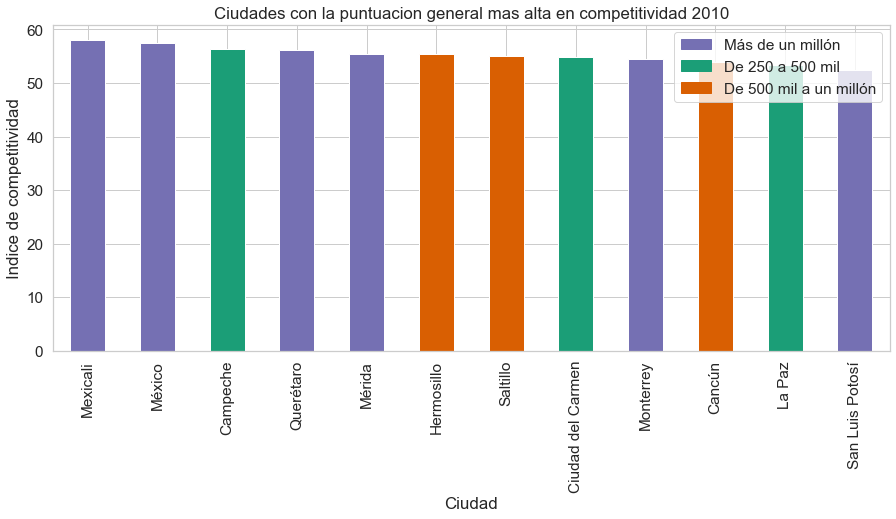

In [413]:
#Cuales son las ciudades del 2010 que han quedado en los primeros lugares ?
df_top = df[['Ciudad','poblacion', 'anio', 'GENERAL', 'tamaño']].drop_duplicates(keep = 'first')
df_top = df_top[df.anio==2010].sort_values(by='GENERAL',ascending=False).head(12)
c = df_top['tamaño'].unique

result_cat = df_top["tamaño"].astype("category")
result_codes = result_cat.cat.codes.values
cmap = plt.cm.Dark2(range(df_top["tamaño"].unique().shape[0]))

patches = []
for code in result_cat.cat.codes.unique():
    cat = result_cat.cat.categories[code]
    patches.append(mpatches.Patch(color=cmap[code], label=cat))

sns.set_palette("Set2", 8, .75)
sns.set_style('whitegrid')
df_top.plot('Ciudad', 'GENERAL', kind = 'bar', figsize = (15,6), color= cmap[result_codes])

plt.xlabel('Ciudad')
plt.ylabel('Indice de competitividad')
plt.legend(handles=patches)
plt.title('Ciudades con la puntuacion general mas alta en competitividad 2010')

### Indice 2018

Text(0.5, 1.0, 'Ciudades con la puntuacion general mas alta en competitividad 2018')

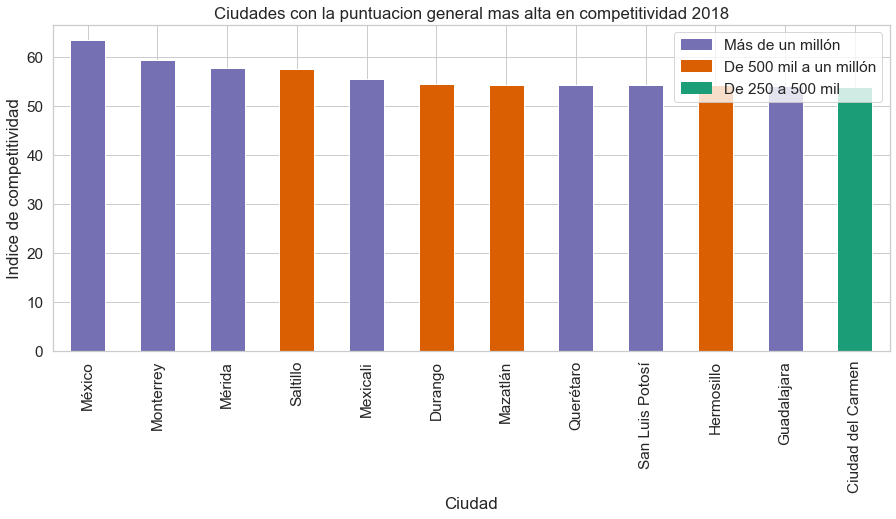

In [414]:
#Y en el 2018?

df_top = df[['Ciudad','poblacion', 'anio', 'GENERAL', 'tamaño']].drop_duplicates(keep = 'first')
df_top = df_top[df.anio==2018].sort_values(by='GENERAL',ascending=False).head(12)
c = df_top['tamaño'].unique

result_cat = df_top["tamaño"].astype("category")
result_codes = result_cat.cat.codes.values
cmap = plt.cm.Dark2(range(df_top["tamaño"].unique().shape[0]))

patches = []
for code in result_cat.cat.codes.unique():
    cat = result_cat.cat.categories[code]
    patches.append(mpatches.Patch(color=cmap[code], label=cat))

sns.set_palette("Set2", 8, .75)
sns.set_style('whitegrid')
df_top.plot('Ciudad', 'GENERAL', kind = 'bar', figsize = (15,6), color= cmap[result_codes])

plt.xlabel('Ciudad')
plt.ylabel('Indice de competitividad')
plt.legend(handles=patches)
plt.title('Ciudades con la puntuacion general mas alta en competitividad 2018')

### Comportamiento en series de tiempo

Text(0.5, 1.0, 'Indice de competitividad por año por ciudad')

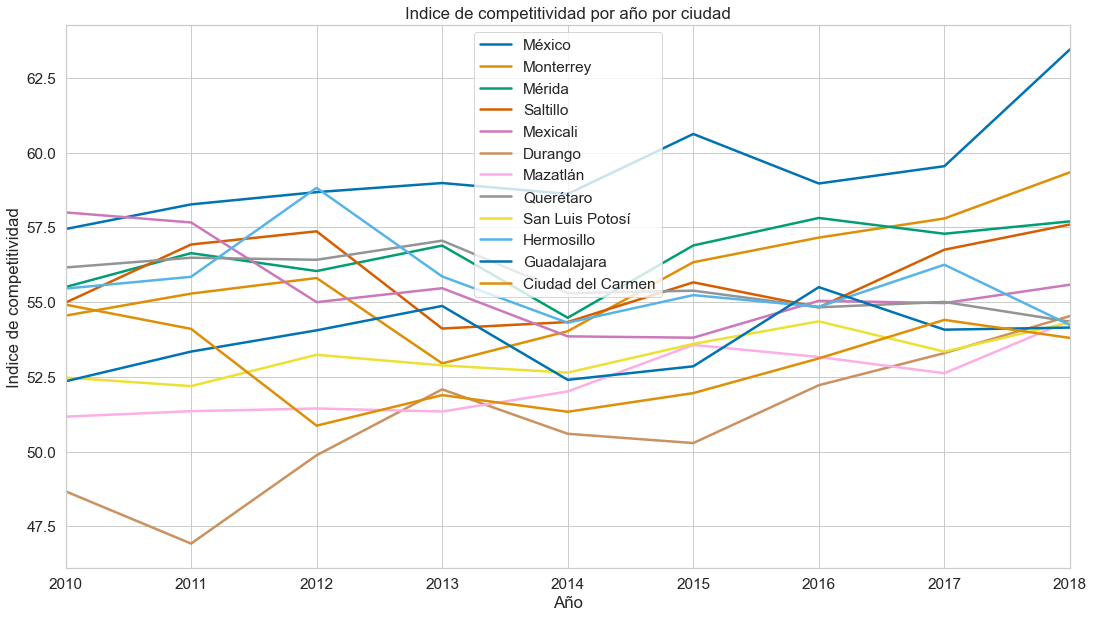

In [415]:
#vemos como se comportaron a lo largo de los años los indices de competitividad general esas 12 ciudades 
#
df_top = df[['Ciudad','poblacion', 'anio', 'GENERAL', 'tamaño']].drop_duplicates(keep = 'first')
df_top = df_top[df.anio==2018].sort_values(by='GENERAL',ascending=False).head(12)
sns.set_palette(sns.color_palette("colorblind",15))
sns.set_style('whitegrid')

fig, ax = plt.subplots()

names = df_top['Ciudad'].tolist()
for name in names:
    ndf = df.loc[df['Ciudad']==name]
    ax = ndf.plot(ax=ax, kind='line', x='anio', y='GENERAL', label=name, figsize=(18,10), linewidth=2.5)
plt.xlim((2010, 2018))
plt.xlabel('Año')
plt.ylabel('Indice de competitividad')
plt.title('Indice de competitividad por año por ciudad')

## Relaciones y correlaciones

### Correlacion

.

<AxesSubplot:>

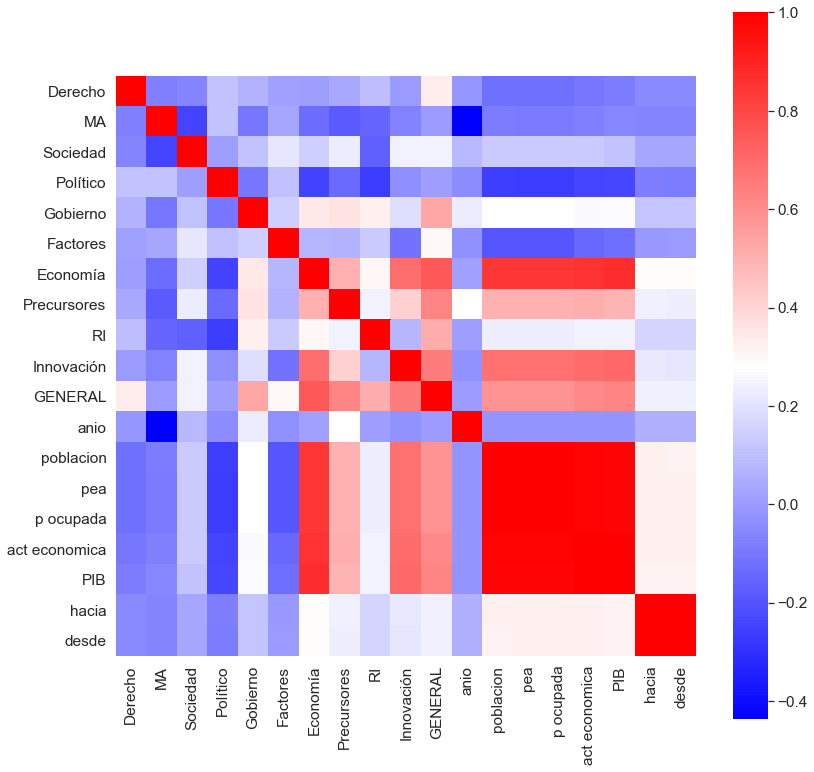

In [416]:
#ahora vamos a ver la correlación que hay entre el numero de vuelos y el indice de competitividad 
#Voy a sacar un subset 
data_num = df._get_numeric_data()
data_cor = data_num.corr(method= 'pearson')

sns.set(font_scale=1.4)

plt.figure(figsize=(13,13))
sns.heatmap(data_cor,  square=True, cmap='bwr')

In [417]:
#Vamos a agrupar
df_group = df.sort_values(['tamaño','anio','Ciudad'],ascending=False).groupby(['tamaño','anio','Ciudad']).mean()

In [418]:
#df_vuelos =  df[['Ciudad','poblacion', 'anio', 'GENERAL', 'tamaño', 'hacia','desde']].drop_duplicates(keep = 'first')
#df_vuelos = df_top[df.anio==2018].sort_values(by='GENERAL',ascending=False).head(12)
#df_vuelos['total_vuelos'] = df_vuelos['hacia'] + df_vuelos['desde']
#df_vuelos

#df_group = df.sort_values(['tamaño','anio','Ciudad'],ascending=False).groupby(['tamaño','anio','Ciudad']).mean()
#df_group

df_group = (df.groupby(['anio','Ciudad'], as_index=False)
       .agg({'hacia':'sum', 'desde':'sum','GENERAL':'mean', 'poblacion':'mean'})
       .rename(columns={'hacia':'suma_salidas', 'desde':'suma_llegadas'}))
df_group['total_vuelos'] = df_group['suma_salidas'] + df_group['suma_llegadas']
df_group

#df = (df.groupby('Name', as_index=False)
#       .agg({'Missed':'sum', 'Credit':'sum','Grade':'mean'})
#       .rename(columns={'Missed':'Sum1', 'Credit':'Sum2','Grade':'Average'}))


,anio,Ciudad,suma_salidas,suma_llegadas,GENERAL,poblacion,total_vuelos
0,2010,Acapulco,280035.0,274624.0,43.980450,913345,554659.0
1,2010,Aguascalientes,110805.0,109463.0,51.599017,1110902,220268.0
2,2010,Campeche,48308.0,48821.0,56.267653,306615,97129.0
3,2010,Cancún,1733259.0,1674377.0,53.975767,827532,3407636.0
4,2010,Chetumal,42800.0,42857.0,48.663109,257030,85657.0
...,...,...,...,...,...,...,...
448,2018,Veracruz,729589.0,716115.0,50.214075,940527,1445704.0
449,2018,Villahermosa,602912.0,578168.0,45.446966,865911,1181080.0
450,2018,Xalapa,0.0,0.0,47.680090,804284,0.0
451,2018,Zacatecas,116773.0,116191.0,48.762407,390499,232964.0


In [419]:
df_group.to_html('./vuelos.html')

### Scatter plot

In [420]:
#Saco un total de vuelos por ciudad por año

fig = px.scatter(df_group, x='GENERAL', y="total_vuelos", color=df_group["poblacion"], hover_data=['anio','Ciudad'], size=df_group['poblacion']/1000000,width=1000, height=600)
fig